In [131]:
import keras
from keras.layers import Dense,Softmax,Dropout
from keras import regularizers
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

tonpyarray = lambda x: np.asarray(x).astype('float32')

In [74]:
 link = "https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/gender_voice_dataset.csv"
 data = pd.read_csv(link)

In [6]:
# Przygotowanie danych do trenowania
def prepareData(data, xlabs):
    data = data.sample(frac=1)
    train_test_percentage = 0.8
    rows = len(data.index)
    train = data.head(int(rows * train_test_percentage))
    test = data.tail(int(rows * (1 - train_test_percentage)))
    
    label_function = lambda s: np.array([1,0]) if s=="male" else np.array([0,1])
    
    x_train = tonpyarray(train[xlabs])
    y_train = tonpyarray(list(train.label.apply(label_function)))
    x_test = tonpyarray(test[xlabs])
    y_test = tonpyarray(list(test.label.apply(label_function)))
    
    return ((x_train, y_train), (x_test, y_test))

### Regularyzacja danych

In [70]:
# Przygotowanie modelu z regularyzacja
def createModelReg(density):
    DenseReg = lambda x : Dense(x,activation='relu', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    )

    modelReg = keras.Sequential()
    modelReg.add(DenseReg(density))
    modelReg.add(Dropout(0.5))
    modelReg.add(DenseReg(density))
    modelReg.add(Dense(2))
    modelReg.add(Softmax())
    modelReg.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return modelReg


In [17]:
# Przygotowanie modelu bez regularyzacji
def createModel(density):
    DenseC = lambda x : Dense(x,activation='relu')

    model = keras.Sequential()
    model.add(DenseC(density))
    model.add(Dropout(0.5))
    model.add(DenseC(density))
    model.add(Dense(2))
    model.add(Softmax())
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [71]:
((x_train, y_train), (x_test, y_test)) = prepareData(data, list(data.columns)[:-1])

model = createModel(512)
modelReg = createModelReg(512)

model.fit(x_train,y_train,epochs=1000,batch_size=20000,verbose=0)
modelReg.fit(x_train,y_train,epochs=1000,batch_size=20000,verbose=0)

model.evaluate(x_test,y_test)
modelReg.evaluate(x_test,y_test)

20/20 [==============================] - 0s 1ms/step - loss: 0.1468 - accuracy: 0.9700


[0.1468023955821991, 0.9699841737747192]

Po testach doszliśmy do wniosku że w tym wypadku regularyzacja wpływa negatywnie na dokładność otrzymywanych wyników, dlatego w dalszych testach będziemy używać tylko modelu bez regularyzacji.

### Wybór zmiennych

We wcześniej wykonanej eksploracji danych doszliśmy do wniosku że zmienne które najlepiej opisują label to `IQR`, `Q25` oraz `meanfun`, z czego `IQR` i `Q25` są dosyć mocno skorelowane.

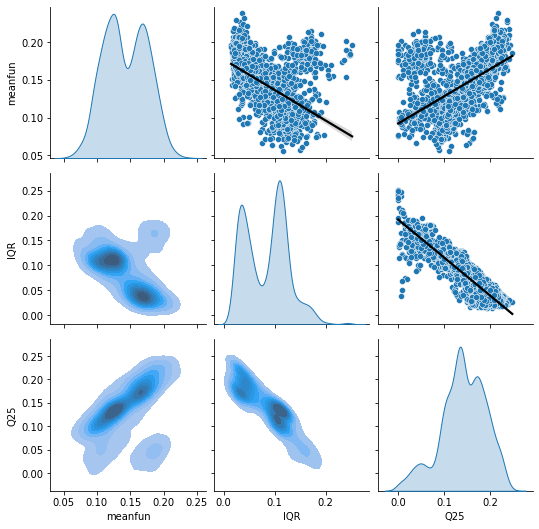

In [67]:
g = sns.pairplot(data[["meanfun","IQR","Q25"]], diag_kind="kde", kind="none")
g.map_lower(sns.kdeplot, fill=True)
g.map_upper(sns.scatterplot)
g.map_upper(sns.regplot, scatter=False, color="black")
    
plt.show()

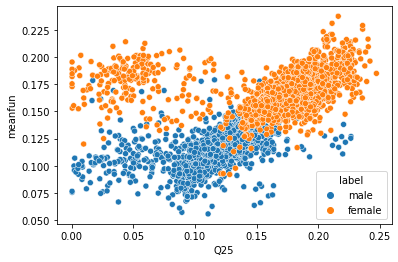

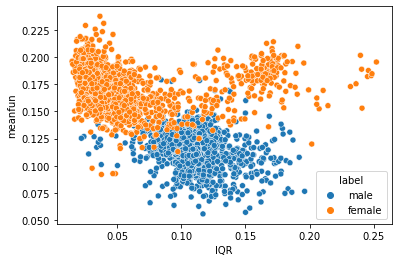

In [68]:
sns.scatterplot(data=data, x='Q25', y='meanfun', hue='label')
plt.show()
sns.scatterplot(data=data, x='IQR', y='meanfun', hue='label')
plt.show()

Sprawdźmy dokładność trzech modeli z ograniczoną liczbą zmiennych wejściowych - `IQR, Q25, meanfun`, `IQR, meanfun` oraz `Q25, meanfun`.

In [18]:
def testModel(xlabs, epochs=1000,batch_size=20000):
    ((x_train, y_train), (x_test, y_test)) = prepareData(data, xlabs)
    model = createModel(256)
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)
    model.evaluate(x_test,y_test)

testModel(['IQR','Q25','meanfun'])
testModel(['IQR','meanfun'])
testModel(['Q25','meanfun'])
testModel(['meanfun'])


20/20 [==============================] - 0s 527us/step - loss: 0.1810 - accuracy: 0.9447


Ze wszystkich modeli, `IQR, Q25, meanfun` daje największą dokładność, większą nawet niż wykorzystanie wszystkich dostępnych zmiennych.

## Porównanie wobec innych modeli
### Drzewa decyzyjne

In [121]:
def testTreeModel(xlabs):
    ((x_train, y_train), (x_test, y_test)) = prepareData(data, xlabs)
    model = DecisionTreeClassifier(max_depth = 8, random_state=1)
    model.fit(x_train,y_train)
    print(model.score(x_test,y_test))

testTreeModel(list(data.columns[:-1]))
testTreeModel(['IQR','Q25','meanfun'])
testTreeModel(['IQR','meanfun'])
testTreeModel(['Q25','meanfun'])
testTreeModel(['meanfun'])

0.9605055292259084
0.9636650868878357
0.9415481832543444
0.9589257503949447
0.9162717219589257


Dla drzew decyzyjnych dokładność wyników jest znacząco niższa w porównaniu do poprzedniego modelu, zatem odpada jako kandydat na model końcowy.

### Sąsiedzi

In [116]:
def testKNeighborsModel(xlabs):
    ((x_train, y_train), (x_test, y_test)) = prepareData(data, xlabs)
    model = KNeighborsClassifier()
    model.fit(x_train,y_train)
    print(model.score(x_test,y_test))

testKNeighborsModel(list(data.columns[:-1]))
testKNeighborsModel(['IQR','Q25','meanfun'])
testKNeighborsModel(['IQR','meanfun'])
testKNeighborsModel(['Q25','meanfun'])
testKNeighborsModel(['meanfun'])

0.7424960505529226
0.9731437598736177
0.9636650868878357
0.9620853080568721
0.9383886255924171


Ten model daje całkiem wysoką dokładność, zatem należy go uwzględnić podczas tworzenia modelu końcowego. Widać także bardzo niską dokładność przy braku zawężenia kategorii.

### Boosted trees

In [132]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(2534)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(2534))
    return dataset
  return input_fn

def testBoostedTrees(dat,xlabs):
    label_function = lambda s: 1 if s=="male" else 0

    fc = tf.feature_column

    train_test_percentage = 0.8
    #data = pd.read_csv('https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/gender_voice_dataset.csv').sample(frac=1)[xlabs + ['label']]
    data = dat.copy(deep=True).sample(frac=1)[xlabs + ['label']]

    def one_hot_cat_column(feature_name, vocab):
      return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
    rows = len(data.index)
    dftrain = data.head(int(rows * train_test_percentage))
    dfeval = data.tail(int(rows * (1 - train_test_percentage)))
    y_train = dftrain.pop('label')
    y_eval = dfeval.pop('label')
    y_train = tonpyarray(list(y_train.apply(label_function)))
    y_eval = tonpyarray(list(y_eval.apply(label_function)))

    params = {
      'n_trees': 100,
      'max_depth': 6,
      'n_batches_per_layer': 1,
      'center_bias': True
    }
    
    feature_columns = []
    for feature_name in xlabs:
      feature_columns.append(fc.numeric_column(feature_name,
                                               dtype=tf.float32))

    est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    # Train model.
    train_input_fn = make_input_fn(dftrain, y_train)
    est.train(train_input_fn, max_steps=600)

    # # Evaluation.
    eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
    print(est.evaluate(eval_input_fn))

*Kod stworzony na bazie [tej części dokumentacji](https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding).*

In [136]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('WARNING')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

testBoostedTrees(data, list(data.columns[:-1]))
testBoostedTrees(data, ['IQR','Q25','meanfun'])
testBoostedTrees(data, ['IQR','meanfun'])
testBoostedTrees(data, ['Q25','meanfun'])
testBoostedTrees(data, ['meanfun'])

{'accuracy': 0.98894155, 'accuracy_baseline': 0.5134281, 'auc': 0.99181324, 'auc_precision_recall': 0.994837, 'average_loss': 0.08635518, 'label/mean': 0.48657188, 'loss': 0.08635518, 'precision': 0.9934426, 'prediction/mean': 0.48183128, 'recall': 0.98376626, 'global_step': 600}
{'accuracy': 0.9620853, 'accuracy_baseline': 0.5039494, 'auc': 0.98224956, 'auc_precision_recall': 0.9848879, 'average_loss': 0.19966544, 'label/mean': 0.49605057, 'loss': 0.19966544, 'precision': 0.96178347, 'prediction/mean': 0.49868667, 'recall': 0.96178347, 'global_step': 600}
{'accuracy': 0.9557662, 'accuracy_baseline': 0.52922595, 'auc': 0.9755986, 'auc_precision_recall': 0.97614104, 'average_loss': 0.28842837, 'label/mean': 0.47077408, 'loss': 0.28842837, 'precision': 0.95, 'prediction/mean': 0.47508103, 'recall': 0.95637584, 'global_step': 600}
{'accuracy': 0.95418644, 'accuracy_baseline': 0.51184833, 'auc': 0.9786598, 'auc_precision_recall': 0.9810137, 'average_loss': 0.24851568, 'label/mean': 0.51184

Ten model daje bardzo wysoką dokładność przy trenowaniu na pełnym zakresie zmiennych, większą niż wszystkie pozostałe modele. Jednak znacząco ona spada przy zawężeniu zmiennych, co trzeba będzie uwzględnić przy tworzeniu finalnego modelu.